<a href="https://colab.research.google.com/github/r-o-h-a-n-2004/faster-rcnn-object-detection-/blob/main/faster_rcnn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40 - Train Loss: 0.9167, LR: 0.001000
Epoch 2/40 - Train Loss: 0.6184, LR: 0.001000
Epoch 3/40 - Train Loss: 0.5271, LR: 0.001000
Epoch 4/40 - Train Loss: 0.4872, LR: 0.001000
Epoch 5/40 - Train Loss: 0.4335, LR: 0.001000
Epoch 6/40 - Train Loss: 0.3855, LR: 0.001000
Epoch 7/40 - Train Loss: 0.3563, LR: 0.001000
Epoch 8/40 - Train Loss: 0.3346, LR: 0.001000
Epoch 9/40 - Train Loss: 0.3234, LR: 0.001000
Epoch 10/40 - Train Loss: 0.3159, LR: 0.001000
Epoch 11/40 - Train Loss: 0.2961, LR: 0.001000
Epoch 12/40 - Train Loss: 0.2970, LR: 0.001000
Epoch 13/40 - Train Loss: 0.2842, LR: 0.001000
Epoch 14/40 - Train Loss: 0.2664, LR: 0.001000
Epoch 15/40 - Train Loss: 0.2678, LR: 0.001000
Epoch 16/40 - Train Loss: 0.2587, LR: 0.001000
Epoch 17/40 - Train Loss: 0.2523, LR: 0.001000
Epoch 18/40 - Train Loss: 0.2436, LR: 0.001000
Epoch 19/40 - Train Loss: 0.2410, LR: 0.001000
Epoch 20/40 - Train Loss: 0.2341, LR: 0.001000
Epoch 21/40 - Train Loss: 0.2283, LR: 0.001000
Epoch 22/40 - Train Lo

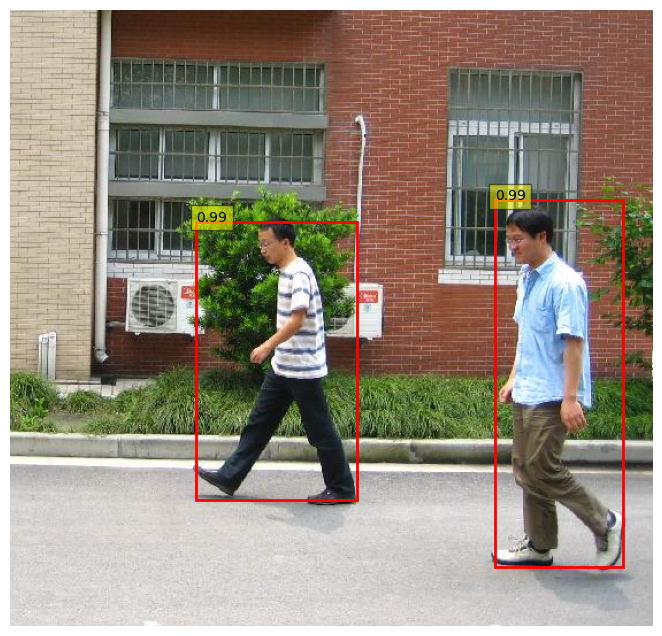


Image 2 - Detected pedestrians: 3


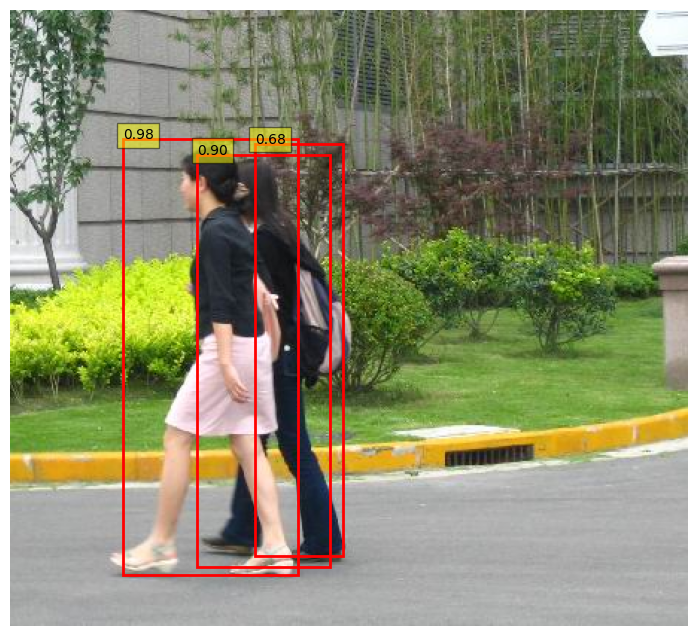


Image 3 - Detected pedestrians: 1


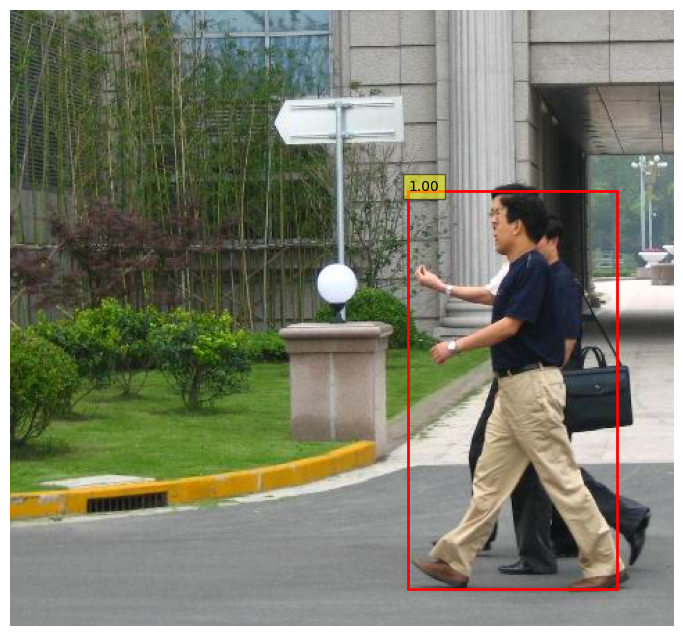


Image 4 - Detected pedestrians: 2


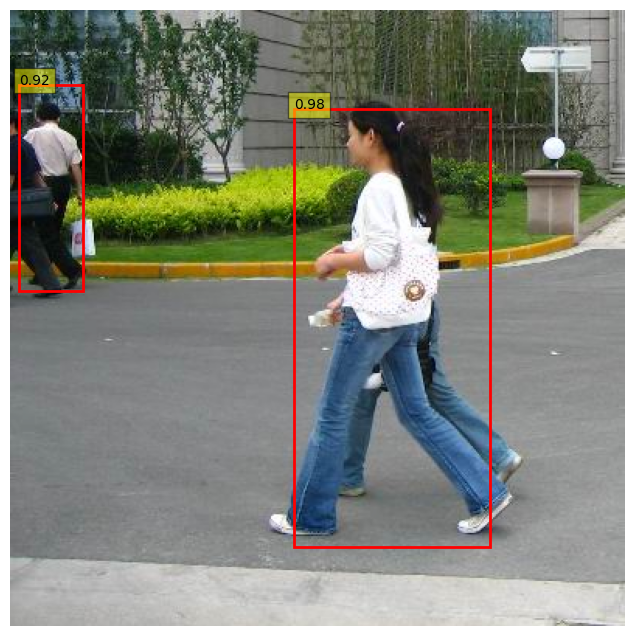


Image 5 - Detected pedestrians: 2


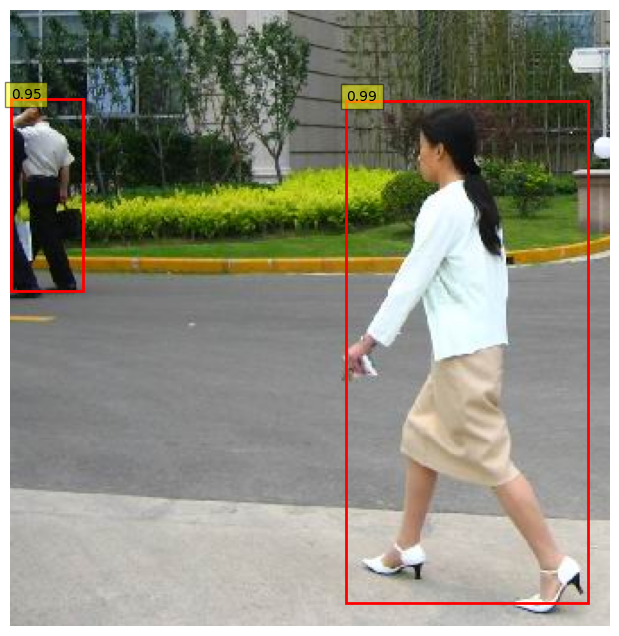

In [8]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download and extract dataset
!wget -q https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q -o PennFudanPed.zip
!rm PennFudanPed.zip

# Custom dataset class with data augmentation
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None, augment=False):
        self.root = root
        self.transforms = transforms
        self.augment = augment
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Get unique object ids (0 is background)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        # Create binary masks for each object
        masks = mask == obj_ids[:, None, None]

        # Extract bounding boxes
        boxes = []
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            # Ensure boxes have valid dimensions
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])

        # Apply data augmentation
        if self.augment and random.random() > 0.5:
            # Horizontal flip
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            width = img.width
            boxes = [[width - xmax, ymin, width - xmin, ymax] for (xmin, ymin, xmax, ymax) in boxes]

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # All pedestrians
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms if specified
        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Data transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

# Create dataset instances with augmentation for training
train_dataset = PennFudanDataset("PennFudanPed", transforms=transform, augment=True)
test_dataset = PennFudanDataset("PennFudanPed", transforms=transform, augment=False)

# Split dataset (80% train, 20% test)
indices = torch.randperm(len(train_dataset)).tolist()
split_idx = int(0.8 * len(train_dataset))
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Custom collate function to handle varying numbers of objects
def collate_fn(batch):
    return tuple(zip(*batch))

# Data loaders
train_loader = DataLoader(
    train_subset, batch_size=4, shuffle=True,  # Increased batch size
    num_workers=2, collate_fn=collate_fn)

val_loader = DataLoader(
    val_subset, batch_size=2, shuffle=False,
    num_workers=2, collate_fn=collate_fn)

test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False,
    num_workers=2, collate_fn=collate_fn)

# Create model with ResNet18 backbone (more capacity)
def create_faster_rcnn(num_classes):
    # Use ResNet18 backbone for better performance
    backbone = torchvision.models.resnet18(pretrained=True)
    backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))  # Remove avgpool and fc
    backbone.out_channels = 512  # Output channels from ResNet18

    # Anchor generator with more aspect ratios
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.25, 0.5, 1.0, 2.0, 4.0),)
    )

    # ROI pooling
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    # Create Faster R-CNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        box_detections_per_img=100  # More detections for better recall
    )

    return model

# Initialize model
num_classes = 2  # Background + pedestrian
model = create_faster_rcnn(num_classes)
model.to(device)

# Optimizer with adjusted parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.001,  # Reduced learning rate
    momentum=0.9,
    weight_decay=0.0005,  # Regularization
    nesterov=True
)

# Learning rate scheduler with plateau detection
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

# Training function with validation
def train_model(model, optimizer, train_loader, val_loader, num_epochs=40):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_loss += losses.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Model returns a list of dictionaries in evaluation mode
                predictions = model(images)
                # Since we are in eval mode, we don't have a loss dictionary.
                # For validation loss, we would typically calculate a metric like mAP.
                # However, for simplicity in this example, we'll skip calculating
                # a validation loss and focus on the training progress.
                # If you need to monitor validation loss, you'd need to implement
                # a separate function to calculate appropriate metrics.
                pass # Skipping validation loss calculation in this simplified example

        # Update learning rate based on training loss for this example
        lr_scheduler.step(avg_train_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model based on a metric (e.g., mAP), not loss, in a real scenario.
        # For this example, we'll just save the model after the last epoch.
        if epoch == num_epochs - 1:
             torch.save(model.state_dict(), 'final_model.pth')
             print("Saved final model")


    print("Training complete!")

# Train the model
train_model(model, optimizer, train_loader, val_loader, num_epochs=40)

# Load best model
model.load_state_dict(torch.load('final_model.pth'))
print("Loaded final model for testing")

# Save trained model
torch.save(model.state_dict(), 'faster_rcnn_pedestrian.pth')
print("Model saved!")

# Visualization function
def visualize_detections(image, boxes, scores=None, threshold=0.5):
    """Draw bounding boxes on image"""
    # Convert tensor to numpy array and denormalize
    img = image.cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < threshold:
            continue

        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        if scores is not None:
            ax.text(xmin, ymin, f'{scores[i]:.2f}',
                    bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Test the model with NMS and confidence thresholding
def test_model(model, data_loader, num_samples=5, iou_threshold=0.5, confidence_threshold=0.5):
    model.eval()
    sample_count = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            # Visualize results
            for i in range(len(images)):
                img = images[i].cpu()
                boxes = predictions[i]['boxes'].cpu()
                scores = predictions[i]['scores'].cpu()

                # Apply Non-Maximum Suppression (NMS)
                if len(boxes) > 0:
                    keep_indices = torchvision.ops.nms(boxes, scores, iou_threshold)
                    filtered_boxes = boxes[keep_indices]
                    filtered_scores = scores[keep_indices]

                    # Apply confidence threshold
                    high_conf = filtered_scores > confidence_threshold
                    final_boxes = filtered_boxes[high_conf]
                    final_scores = filtered_scores[high_conf]
                else:
                    final_boxes = boxes
                    final_scores = scores

                print(f"\nImage {sample_count + 1} - Detected pedestrians: {len(final_boxes)}")
                visualize_detections(img, final_boxes, final_scores, threshold=confidence_threshold)

                sample_count += 1
                if sample_count >= num_samples:
                    return

# Run evaluation on test images with NMS
print("\nTesting model on sample images with NMS...")
test_model(model, test_loader, num_samples=5, iou_threshold=0.5, confidence_threshold=0.5)